# Image Comparison v 1.0

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_bounding_boxes_on_changes_and_save(image_path1, image_path2, save_path):
    # Load the images
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    # Check if images were loaded
    if img1 is None or img2 is None:
        raise FileNotFoundError("One or both images could not be loaded.")

    # Ensure images are the same size
    if img1.shape != img2.shape:
        raise ValueError("Images must have the same dimensions.")

    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Calculate the absolute difference between the images
    diff = cv2.absdiff(gray1, gray2)

    # Threshold the diff image
    _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # Find contours from the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding boxes on img2
    for contour in contours:
        if cv2.contourArea(contour) > 0:  # Filter out small changes
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(img2, (x, y), (x+w, y+h), (0, 255,0), 2)

    # Save the modified image
    cv2.imwrite(save_path, img2)

    # Convert BGR to RGB for matplotlib compatibility
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Display the second image with bounding boxes
    plt.imshow(img2_rgb)
    plt.title('Second Image with Bounding Boxes')
    plt.axis('off')
    plt.show()

# Example usage
draw_bounding_boxes_on_changes_and_save('/Users/jatavathpavannaik/Documents/ICodeTest/Booking.com_1.png', '/Users/jatavathpavannaik/Documents/ICodeTest/Booking.com_2.png', 'processed_image.jpg')


# Image Comparison v 2.0

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def group_contours(contours, horizontal_proximity=30, vertical_proximity=30):
    def are_close(c1, c2):
        x1, y1, w1, h1 = cv2.boundingRect(c1)
        x2, y2, w2, h2 = cv2.boundingRect(c2)

        # Check horizontal closeness
        horizontal_close = (abs(x1 - x2) <= horizontal_proximity or abs((x1 + w1) - (x2 + w2)) <= horizontal_proximity)

        # Check vertical closeness
        vertical_close = (abs(y1 - y2) <= vertical_proximity or abs((y1 + h1) - (y2 + h2)) <= vertical_proximity)

        return horizontal_close and vertical_close

    groups = []
    used = set()

    for i in range(len(contours)):
        if i in used:
            continue
        group = [contours[i]]
        queue = [i]
        used.add(i)
        while queue:
            idx = queue.pop(0)
            for j in range(len(contours)):
                if j not in used and are_close(contours[idx], contours[j]):
                    used.add(j)
                    queue.append(j)
                    group.append(contours[j])
        groups.append(group)
    return groups


def draw_bounding_boxes_on_changes_and_save(image_path1, image_path2, save_path):
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    if img1 is None or img2 is None:
        raise FileNotFoundError("One or both images could not be loaded.")

    if img1.shape != img2.shape:
        raise ValueError("Images must have the same dimensions.")

    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    diff = cv2.absdiff(gray1, gray2)
    _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = [c for c in contours if cv2.contourArea(c) > 0]
    contour_groups = group_contours(filtered_contours)

    for group in contour_groups:
        all_points = np.vstack([cv2.boxPoints(cv2.minAreaRect(contour)) for contour in group]).astype(int)
        x, y, w, h = cv2.boundingRect(all_points)
        cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)

    cv2.imwrite(save_path, img2)

    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    plt.imshow(img2_rgb)
    plt.title('Second Image with Bounding Boxes')
    plt.axis('off')
    plt.show()

# Example usage
draw_bounding_boxes_on_changes_and_save('with_element.png', 'without_element.png', 'processed_image.jpg')


# Image Tracking v 3.0

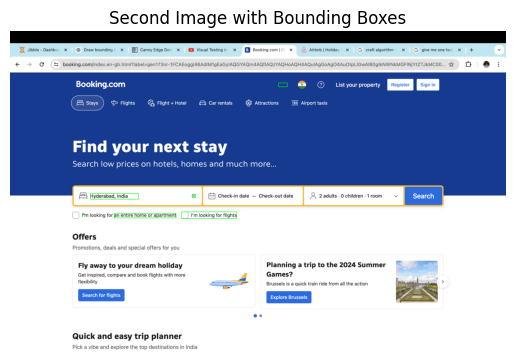

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def group_contours(contours, horizontal_proximity=30, vertical_proximity=30):
    # Defines a function to determine if two contours are close to each other
    def are_close(c1, c2):
        x1, y1, w1, h1 = cv2.boundingRect(c1)
        x2, y2, w2, h2 = cv2.boundingRect(c2)

        # Check horizontal closeness
        horizontal_close = (x2 <= x1 + w1 + horizontal_proximity) and (x1 <= x2 + w2 + horizontal_proximity)

        # Check vertical closeness
        vertical_close = (y2 <= y1 + h1 + vertical_proximity) and (y1 <= y2 + h2 + vertical_proximity)

        return horizontal_close and vertical_close

    groups = []
    used = set()

    # Iteratively group close contours
    for i in range(len(contours)):
        if i in used:
            continue
        group = [contours[i]]
        queue = [i]
        used.add(i)
        while queue:
            idx = queue.pop(0)
            for j in range(len(contours)):
                if j not in used and are_close(contours[idx], contours[j]):
                    used.add(j)
                    queue.append(j)
                    group.append(contours[j])
        groups.append(group)
    return groups

def draw_bounding_boxes_on_changes_and_save(image_path1, image_path2, save_path):
    # Load images
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)

    if img1 is None or img2 is None:
        raise FileNotFoundError("One or both images could not be loaded.")

    # Ensure images are the same size
    if img1.shape != img2.shape:
        raise ValueError("Images must have the same dimensions.")

    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Compute the difference and apply threshold
    diff = cv2.absdiff(gray1, gray2)
    _, thresh = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # Find contours from the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out very small contours
    filtered_contours = [c for c in contours if cv2.contourArea(c) > 0]
    contour_groups = group_contours(filtered_contours)

    # Draw bounding boxes around contour groups
    for group in contour_groups:
        all_points = np.vstack([cv2.boxPoints(cv2.minAreaRect(contour)) for contour in group])
        x, y, w, h = cv2.boundingRect(all_points)
        cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Save and display the processed image
    cv2.imwrite(save_path, img2)

    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    plt.imshow(img2_rgb)
    plt.title('Second Image with Bounding Boxes')
    plt.axis('off')
    plt.show()

# Example usage
draw_bounding_boxes_on_changes_and_save('/Users/jatavathpavannaik/Documents/ICodeTest/Test_cases/with_element.png', '/Users/jatavathpavannaik/Documents/ICodeTest/Test_cases/without_element.png', 'processed_image.jpg')


# Delete Duplicated Frames v 1.0

In [ ]:
import cv2
import numpy as np

def remove_stagnant_frames(video_path, output_path, change_threshold=30, area_threshold=100):
    # Setup video capture
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise FileNotFoundError("Video file could not be opened.")

    # Obtain input video frame rate and resolution
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Setup video writer with the same frame rate as the input video
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'XVID'
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
 
    # Read the first frame
    ret, frame1 = cap.read()
    if not ret:
        raise ValueError("Cannot read video file.")
    
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

    while True:
        # Read next frame
        ret, frame2 = cap.read()
        if not ret:
            break
        
        gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        # Calculate the absolute difference and threshold
        diff = cv2.absdiff(gray1, gray2)
        _, thresh = cv2.threshold(diff, change_threshold, 255, cv2.THRESH_BINARY)

        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        significant_change = any(cv2.contourArea(contour) > area_threshold for contour in contours)

        if significant_change:
            out.write(frame2)
            gray1 = gray2  # Update the reference frame to the current frame

    # Cleanup
    cap.release()
    out.release()
    print("Processing complete. Output saved to:", output_path)

# Example usage
remove_stagnant_frames('/Users/jatavathpavannaik/Documents/ICodeTest/Test_cases/Screen Recording 2024-05-19 at 5.25.28 PM.mov', 'output_video.mp4')


# Mouse Tracking v 1.0

In [ ]:
import cv2
import numpy as np

# Bounding box Measurements.
BOX_WIDTH = 40 
BOX_HEIGHT = 40

def process_img(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # converts color to back and white
    kernel = np.ones((5, 5)) # matrix filter (not used any where)
    img_canny = cv2.Canny(img_gray, 50, 50) #edge detection
    return img_canny

def get_contour(img):
    contours, hierarchies = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    if contours:
        return max(contours, key=cv2.contourArea)

def get_line_tip(cnt1, cnt2):
    x1, y1, w1, h1 = cv2.boundingRect(cnt1)

    if h1 > BOX_HEIGHT / 2:
        if np.any(cnt2):
            x2, y2, w2, h2 = cv2.boundingRect(cnt2)
            if x1 < x2:
                return x1, y1
        return x1 + w1, y1

def get_rect(x, y):
    half_width = BOX_WIDTH // 2
    lift_height = BOX_HEIGHT // 6
    return (x - half_width, y - lift_height), (x + half_width, y + BOX_HEIGHT - lift_height)

cap = cv2.VideoCapture("/Users/jatavathpavannaik/Documents/ICodeTest/Test_cases/Screen Recording 2024-05-19 at 5.25.28 PM.mov")
success, img_past = cap.read()

cnt_past = np.array([])
line_tip_past = 0, 0

coordinates=[]
while True:
    success, img_live = cap.read()

    if not success:
        break

    img_live_processed = process_img(img_live)
    img_past_processed = process_img(img_past)

    img_diff = cv2.bitwise_xor(img_live_processed, img_past_processed)
    cnt= get_contour(img_diff)

    line_tip = get_line_tip(cnt, cnt_past)

    if line_tip:
        cnt_past = cnt
        line_tip_past = line_tip
        coordinates.append(line_tip)
    else:
        line_tip = line_tip_past

    rect = get_rect(*line_tip)
    img_past = img_live.copy()
    cv2.rectangle(img_live, *rect, (0, 255, 0), 2)

    cv2.imshow("Cursor", img_live)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
    
cv2.destroyAllWindows()